In [1]:
from numpy import *
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import stats
import pandas as pd
from datetime import datetime, timedelta

import pricingModel as pm
import others as others
import optionPricingFormulas2 as opf2

In [2]:
def readData():
    sigmaData = pd.read_excel("sigmaData.xls")
    sigmaData = sigmaData.where(sigmaData.notnull(), None)
    defaultSigma = None
    defaultTodayPrice = None ###########
    defaultQuantity = None
    
    sigmaDic = {}
    todayPriceDic = {} #todayPrice is the input file day's price and has no relation to the input T
    quantityDic = {}
    liveID = []
    
    for i in range(len(sigmaData)):
        if sigmaData["Unnamed: 1"][i] is not None:
            liveID.append(sigmaData["Unnamed: 1"][i].split()[-1])
            if sigmaData["Vol"][i] is not None:
                sigmaDic[sigmaData["Unnamed: 1"][i].split()[-1]] = (sigmaData["Vol"][i] / 100.0)
            else:
                sigmaDic[sigmaData["Unnamed: 1"][i].split()[-1]] = defaultSigma
            
            if sigmaData["Underlying_Spot"][i] is not None:
                todayPriceDic[sigmaData["Unnamed: 1"][i].split()[-1]] = sigmaData["Underlying_Spot"][i]
            else:
                todayPriceDic[sigmaData["Unnamed: 1"][i].split()[-1]] = defaultTodayPrice
                
            if sigmaData["Quantity"][i] is not None:
                quantityDic[sigmaData["Unnamed: 1"][i].split()[-1]] = sigmaData["Quantity"][i]
            else:
                quantityDic[sigmaData["Unnamed: 1"][i].split()[-1]] = defaultQuantity


    data = pd.read_excel("data.xls")
    data = data.where(data.notnull(), None)
    data.drop([0], axis = 0, inplace = True) #inplace means data = data.changed
    data.reset_index(drop = True, inplace = True)
    data.rename(columns = {"AGGREGATION":"AGGREGATION BUNDLE"}, inplace = True)
    
    liveIDBoolSet = []
    for ID in data["AGGREGATION BUNDLE"]:
        if ID in liveID:
            liveIDBoolSet.append(True)
        else:
            liveIDBoolSet.append(False)
    data = data[liveIDBoolSet]
    data.reset_index(drop = True, inplace = True)

    
    data["k"] = data["执行价格"]
    data["startingPrice"] = data["期初价格"]
    
    s0Set = []
    for i in range(len(data)):
        if data["AGGREGATION BUNDLE"][i] in todayPriceDic:
            s0Set.append(todayPriceDic[data["AGGREGATION BUNDLE"][i]])
        else:
            s0Set.append(defaultTodayPrice)
    data["s0"] = s0Set

    sigmaSet = []
    for i in range(len(data)):
        if data["AGGREGATION BUNDLE"][i] in sigmaDic:
            sigmaSet.append(sigmaDic[data["AGGREGATION BUNDLE"][i]])
        else:
            sigmaSet.append(defaultSigma)
    data["sigma"] = sigmaSet
    
    quantitySet = []
    for i in range(len(data)):
        if data["AGGREGATION BUNDLE"][i] in quantityDic:
            quantitySet.append(quantityDic[data["AGGREGATION BUNDLE"][i]])
        else:
            quantitySet.append(defaultQuantity)
    data["quantity"] = quantitySet
    
    buySet = []
    for i in range(len(data)):
        if data["Buy/Sell"][i] == "Buy":
            buySet.append(True)
        else:
            buySet.append(False)
    data["buy"] = buySet
    
    data["price"] = None
    data["delta"] = None
    data["gamma"] = None
    data["vega"] = None
    data["theta"] = None
    return data

def setT(data, today):
    T_tmp = []
    setDay = datetime.strptime(today, '%Y-%m-%d') #fixed format
    for daysDelta in (data["期末定价日"] - setDay):
        if type(daysDelta.days) != type(int(1)): #should be type.int
            T_tmp.append(int(0))
        elif daysDelta.days < 0:
            T_tmp.append(int(0))
        else:
            T_tmp.append(daysDelta.days)
    data["T"] = T_tmp #it means from the chosen date to the end date
    return data

In [3]:
data = readData()
data = setT(data,"2019-07-08")

In [6]:
data[data["AGGREGATION BUNDLE"] == "19479580"].index

Int64Index([173], dtype='int64')

In [7]:
data.iloc[173]

AGGREGATION BUNDLE                    19479580
Product Reference     JNNSH2019001-315.6.VCALL
类型                                       VCALL
Sub Type                              European
涨跌                                        CALL
欧式\美式                                 European
WIND代码                                  AU1912
结构简称                                      None
期初定价日                      2019-06-27 00:00:00
期末定价日                      2019-09-25 00:00:00
期权费支付日                     2019-06-27 00:00:00
收益兑付日                      2019-09-27 00:00:00
计划期限                                        92
执行价格                                     315.6
上障碍                                       None
下障碍                                       None
上障碍价格                                        0
下障碍价格                                        0
Option Rebate                                0
Digital amount                            None
合约参与率                                     None
合同参与率        

In [17]:
#computePrice(data, dataType, indexToFind, timeShift, s0IsOne, rf, dt, s0Shock, sigmaShock)
[price_tmp, delta_tmp, gamma_tmp, vega_tmp, theta_tmp] = pm.computeCallData(data, 173, 0, False, 0.0245, 1/365, 1, 1)

In [25]:
final = datetime.strptime("2019-9-25", '%Y-%m-%d')
startDay = datetime.strptime("2019-07-08", '%Y-%m-%d')
(final - startDay).days

79

In [20]:
data["s0"][173]

316.35

In [24]:
sss = data["s0"][173] * exp(-1 * 0.0245 * 168/365)
sss

312.8026508639136

In [18]:
price_tmp / data["startingPrice"][173]

0.03073556982153795

In [36]:
opf2.call(314.675, 315.6, 0.144248, 0.0245, 79/365, q = 0) / data["startingPrice"][173]

0.027852818955208816

In [ ]:
log(316.35 / 314.675)

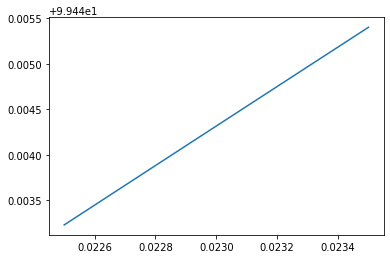

In [255]:
delta = []
r = linspace(0.0225, 0.0235, 101)
for rf in r:
    [price_tmp, delta_tmp, gamma_tmp, vega_tmp, theta_tmp] = pm.computeCallData(data, 19, 0, False, rf, 1/365, 1, 1)
    delta.append(delta_tmp * 100)
plt.plot(r, delta)

In [249]:
gamma_tmp * 100

0.007580170609855685

In [167]:
#-99.4317, -0.00745

In [290]:
data[data["AGGREGATION BUNDLE"] == "19577342"].index

Int64Index([146], dtype='int64')

In [291]:
data.iloc[146]

AGGREGATION BUNDLE                  19577342
Product Reference     OTC2019109-46783.2.DBC
类型                                       DBC
Sub Type                             BARRIER
涨跌                                      CALL
欧式\美式                               European
WIND代码                                CU1909
结构简称                                    None
期初定价日                    2019-07-05 00:00:00
期末定价日                    2019-08-05 00:00:00
期权费支付日                   2019-08-07 00:00:00
收益兑付日                    2019-08-07 00:00:00
计划期限                                      31
执行价格                                 46783.2
上障碍                                      OUT
下障碍                                      OUT
上障碍价格                                49099.2
下障碍价格                                43540.8
Option Rebate                      0.0116667
Digital amount                          None
合约参与率                                   None
合同参与率                                 150.0%
绝对名义本金    

In [292]:
k_tmp, s0_tmp, T_tmp, barrierL_tmp, barrierU_tmp, rebate_tmp, sigma, amplifier = data.loc[146, ["k", "s0", "T", "下障碍价格", 
                                                                                                     "上障碍价格", 
                                                                                                     "Option Rebate", "sigma", 
                                                                                                     "合同参与率"]]
sigma = sigma * 1
s0_tmp = s0_tmp * 1
a = float(amplifier[:-1]) / 100
a = 1
T_tmp = T_tmp - 0
T_tmp = T_tmp / 365
rebate_tmp = rebate_tmp * data["startingPrice"][146] / a


In [293]:
barrierL_tmp

43540.8

In [294]:
opf2.dboc(s0_tmp, k_tmp, barrierL_tmp, barrierU_tmp, rebate_tmp, sigma, 0.023, T_tmp, 1/365, 0)

338.85355510266976

In [300]:
data["startingPrice"][146]

46320.0

In [301]:
data.loc[146, "Option Rebate"]

0.011666666666667

In [296]:
#def dboc(s0, k, b1, b2, rb, v, r, T, dt = 0, q = 0):
#opf2.dboc(s0_tmp, k_tmp, barrierL_tmp, barrierU_tmp, rebate_tmp, sigma, rf, T_tmp, dt) * a

In [297]:
opf2.dboc0rb(s0_tmp, k_tmp, barrierL_tmp, barrierU_tmp, sigma, 0.023, T_tmp, 1/365, 0)

291.7433323983723

In [298]:
opf2.dbudi(s0_tmp, k_tmp, barrierL_tmp, barrierU_tmp, sigma, 0.023, T_tmp, 1/365, 0)

0.08717657791320532

In [299]:
rebate_tmp * opf2.dbudi(s0_tmp, k_tmp, barrierL_tmp, barrierU_tmp, sigma, 0.023, T_tmp, 1/365, 0)

47.1102227042975

In [46]:
47/1.5

31.333333333333332

In [302]:
data[data["AGGREGATION BUNDLE"] == "19577343"].index

Int64Index([147], dtype='int64')

In [303]:
#computePrice(data, dataType, indexToFind, timeShift, s0IsOne, rf, dt, s0Shock, sigmaShock)
[price_tmp, delta_tmp, gamma_tmp, vega_tmp, theta_tmp] = pm.computeDBPData(data, 147, 0, False, 0.023, 1/365, 1, 1)

In [304]:
price_tmp

293.0268274495188

In [305]:
k_tmp, s0_tmp, T_tmp, barrierL_tmp, barrierU_tmp, rebate_tmp, sigma, amplifier = data.loc[147, ["k", "s0", "T", "下障碍价格", 
                                                                                                     "上障碍价格", 
                                                                                                     "Option Rebate", "sigma", 
                                                                                                     "合同参与率"]]
sigma = sigma * 1
s0_tmp = s0_tmp * 1
a = float(amplifier[:-1]) / 100
a = 1
T_tmp = T_tmp + 0
T_tmp = T_tmp / 365
rebate_tmp = rebate_tmp * data["startingPrice"][147] / a


In [306]:
opf2.dbop(s0_tmp, k_tmp, barrierL_tmp, barrierU_tmp, rebate_tmp, sigma, 0.023, T_tmp, 1/365, 0)

293.0268274495188

In [307]:
p2 = opf2.dbudi(s0_tmp, k_tmp, barrierL_tmp, barrierU_tmp, sigma, 0.023, T_tmp, 1/365, 0)

In [308]:
rebate_tmp

540.4000000000154

In [309]:
opf2.dbop0rb(s0_tmp, k_tmp, barrierL_tmp, barrierU_tmp, sigma, 0.023, T_tmp, 1/365, 0)

245.91660474522132

In [119]:
p1 + rebate_tmp * p2 * 1.3

307.1598942608081

In [116]:
p2

0.08717657791320532

In [117]:
p1

245.91660474522132